In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold

## I. Preprocessing

In [24]:
data_folder = "./data/"
df_train = pd.read_csv(data_folder + "train.csv")
df_test = pd.read_csv(data_folder + "test.csv")
target = 'SalePrice'

# Missing values
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('absent')
df_train['GarageFinish']=df_train['GarageFinish'].fillna('absent')
df_train['GarageType']= df_train['GarageType'].fillna('absent')
df_train['BsmtQual']= df_train['BsmtQual'].fillna('absent')
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna('absent')

df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna('absent')
df_test['GarageFinish']=df_test['GarageFinish'].fillna('absent')
df_test['GarageType']= df_test['GarageType'].fillna('absent')
df_test['BsmtQual']= df_test['BsmtQual'].fillna('absent')
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].fillna('absent')

# Imbalanced classes
df_train['ExterQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_train['BsmtQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_train['KitchenQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_train['FireplaceQu'].replace({'Ex': 'Gd', 'Fa': 'TA', 'Po':'TA'}, inplace=True)
df_train['Foundation'].replace({'Wood': 'Other', 'Stone': 'Other', 'Slab':'Other'}, inplace=True)
df_train['GarageType'].replace({'2Types': 'Attchd', 'CarPort': 'absent'}, inplace=True)

df_test['ExterQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_test['BsmtQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_test['KitchenQual'].replace({'Ex': 'Gd', 'Fa': 'TA'}, inplace=True)
df_test['FireplaceQu'].replace({'Ex': 'Gd', 'Fa': 'TA', 'Po':'TA'}, inplace=True)
df_test['Foundation'].replace({'Wood': 'Other', 'Stone': 'Other', 'Slab':'Other'}, inplace=True)
df_test['GarageType'].replace({'2Types': 'Attchd', 'CarPort': 'absent'}, inplace=True)

# Outliers
drop_id = [1299,692,1183]
df_train = df_train[~df_train["Id"].isin(drop_id)]

# New features / Transformations
df_train["TotArea"] = df_train['GrLivArea']+df_train['TotalBsmtSF']
df_train["log_TotArea"]=np.log(df_train['TotArea'])
df_train["log_price"]=np.log(df_train['SalePrice'])
df_train["log_TotArea_2"] = df_train["log_TotArea"]**2
df_train["YearBuilt_2"] = df_train["YearBuilt"]**2 

df_test["TotArea"] = df_test['GrLivArea']+df_test['TotalBsmtSF']
df_test["log_TotArea"]=np.log(df_test['TotArea'])
df_test["log_TotArea_2"] = df_test["log_TotArea"]**2
df_test["YearBuilt_2"] = df_test["YearBuilt"]**2 

# Select variables
target = 'log_price'
var_num_selected = ['GarageCars',
                    'FullBath',
                    'YearBuilt',
                    'log_TotArea',
                    'log_TotArea_2',
                    'YearBuilt_2'
                    ]

var_cat_selected = ['Neighborhood',
                    'ExterQual',
                    'BsmtQual',
                    'KitchenQual',
                    'GarageFinish',
                    'FireplaceQu',
                    'Foundation',
                    'GarageType',
                    'MSSubClass',
                    'BsmtFinType1'
                    ]

y = df_train[target]
df_train = df_train[var_cat_selected + var_num_selected]
df_test = df_test[var_cat_selected + var_num_selected]

# One-hot encoding
df_train['MSSubClass'] = df_train['MSSubClass'].astype('str')
df_test['MSSubClass'] = df_test['MSSubClass'].astype('str')
df_test['MSSubClass'].replace({'150': '20'}, inplace=True) # We replace a value that doesn't exist in df_train by the value most represented 

df_combined = pd.concat([df_train, df_test], keys=['train', 'test'])
df_combined_encoded = pd.get_dummies(df_combined, columns=var_cat_selected)
df_train= df_combined_encoded.xs('train', level=0)
df_test = df_combined_encoded.xs('test', level=0)

## II. Modeling

In [25]:
# Cross validation
kf =KFold(n_splits=5, shuffle=True, random_state=42)
def rmse_cv(model):
    mse= cross_validate(model, df_train, y, scoring="neg_mean_squared_error", cv = kf, return_train_score=True)
    rmse_train = np.sqrt(-np.mean([mse['train_score']]))
    rmse_test = np.sqrt(-np.mean([mse['test_score']]))
    print(f'CV : train rmse {rmse_train} - test rmse {rmse_test}')
    return rmse_train, rmse_test

# Results visualisation
scaler = StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size=0.2, random_state=42)
X_train[var_num_selected] = scaler.fit_transform(X_train[var_num_selected])
X_val[var_num_selected]= scaler.transform(X_val[var_num_selected])

def plot_model(model):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_train_pred = model.predict(X_train)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    
    axes[0,0].scatter(y_train, y_train_pred, marker='+', label = 'train')
    axes[0,0].scatter(y_val, y_val_pred, marker='+', label = 'validation')
    axes[0,0].plot(y_train,y_train, color='red', linestyle='--', label='x=y')
    axes[0,0].legend(loc='upper left')
    axes[0,0].set_title('prediction vs real value of log_price')

    axes[0,1].scatter(y_train, y_train_pred-y_train, marker='+', label = 'train')
    axes[0,1].scatter(y_val, y_val_pred-y_val, marker='+', label = 'validation')
    axes[0,1].legend(loc='upper left')
    axes[0,1].set_title('Residuals vs real value of log_price')

    axes[1,0].scatter(np.exp(y_train), np.exp(y_train_pred), marker='+', label = 'train')
    axes[1,0].scatter(np.exp(y_val), np.exp(y_val_pred), marker='+', label = 'validation')
    axes[1,0].plot(np.exp(y_train),np.exp(y_train), color='red', linestyle='--', label='x=y')
    axes[1,0].legend(loc='upper left')
    axes[1,0].set_title('prediction vs real value of SalePrice')

    axes[1,1].scatter(np.exp(y_train), np.exp(y_train_pred)-np.exp(y_train), marker='+', label = 'train')
    axes[1,1].scatter(np.exp(y_val), np.exp(y_val_pred)-np.exp(y_val), marker='+', label = 'validation')
    axes[1,1].legend(loc='upper left')
    axes[1,1].set_title('Residuals vs real value of SalePrice')

    plt.show()

    return model


### Linear Regression

CV : train rmse 0.1411037253792682 - test rmse 0.15425470404916394


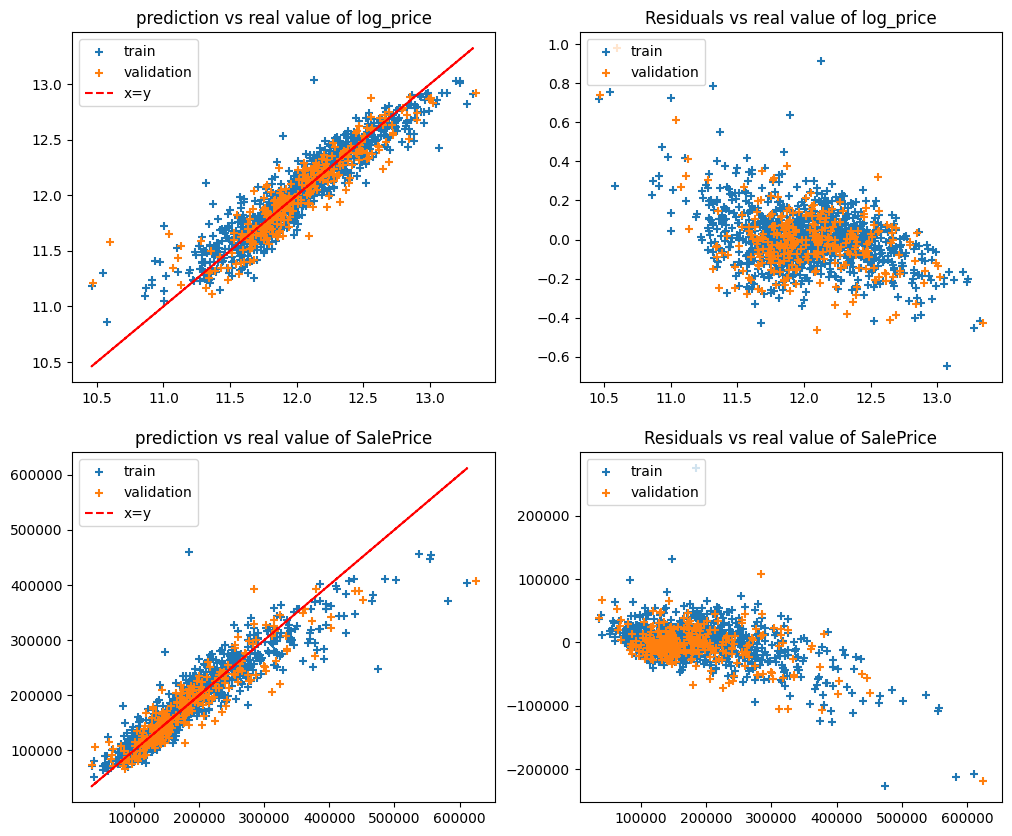

In [26]:

from sklearn.preprocessing import PolynomialFeatures
model = make_pipeline(StandardScaler(), LinearRegression())
rmse_train, rmse_test = rmse_cv(model)

trained_model = plot_model(LinearRegression())


<Axes: xlabel='coefficient', ylabel='feature'>

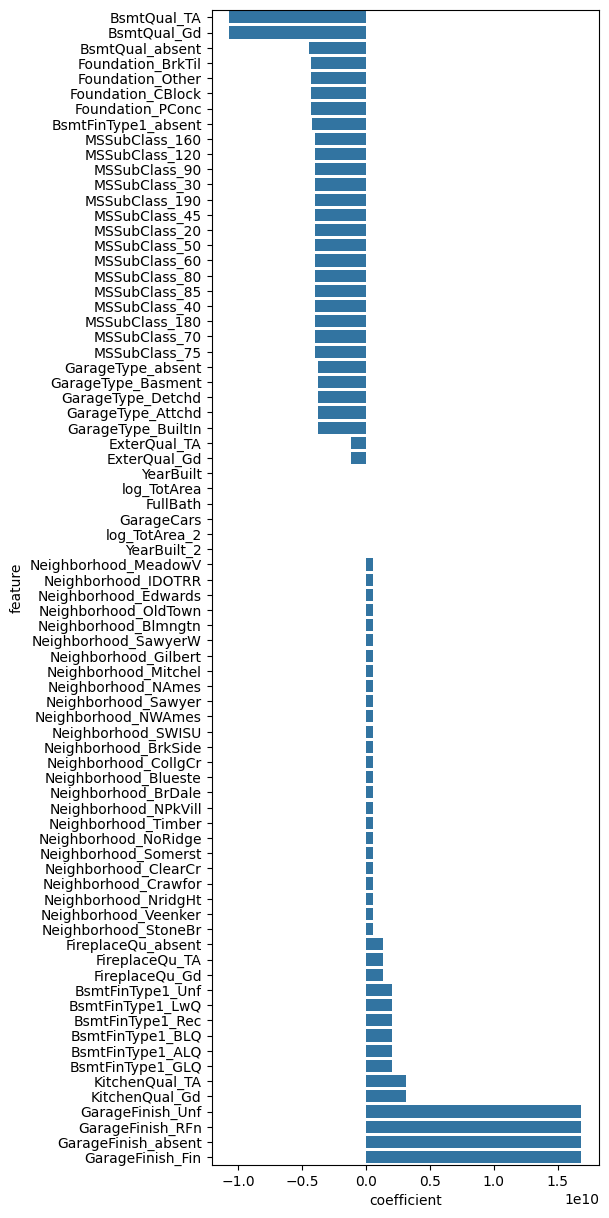

In [27]:
coefficients = trained_model.coef_

df_coeff = pd.DataFrame({'feature':X_train.columns,
              'coefficient':coefficients}
              )
df_coeff.sort_values(by='coefficient', inplace=True)

plt.figure(figsize=(5,15))
sns.barplot(df_coeff, x='coefficient', y='feature', orient='h')

- There is a small difference between performances on training and validation set which means that the variance of the model is good   
- The center of the disribution are well predicted, they are a bit undervalued for high prices and slightly overvalued for small prices  
- The predictions seems pretty good, however some values are very high (1e10). This could mean variables are dependent.  
This is a problem for reliability purpose, in the next part we are going to add some regularization


### Ridge Regression

CV : train rmse 0.14091188963831205 - test rmse 0.1532121116040368
CV : train rmse 0.1409280351642916 - test rmse 0.15297205074066655
CV : train rmse 0.1409755977242428 - test rmse 0.15247274367399924
CV : train rmse 0.14106072335603004 - test rmse 0.1520291348864954
CV : train rmse 0.1411239955201491 - test rmse 0.15181704212423391
CV : train rmse 0.14114333792049882 - test rmse 0.15174303393093552
CV : train rmse 0.1411661605295697 - test rmse 0.1516281800482047
CV : train rmse 0.14118409979447388 - test rmse 0.15153990691612962
CV : train rmse 0.14125073478022723 - test rmse 0.15133514529119463
CV : train rmse 0.14137732285248125 - test rmse 0.15114853967566863
CV : train rmse 0.14158489736000646 - test rmse 0.15101265620703463


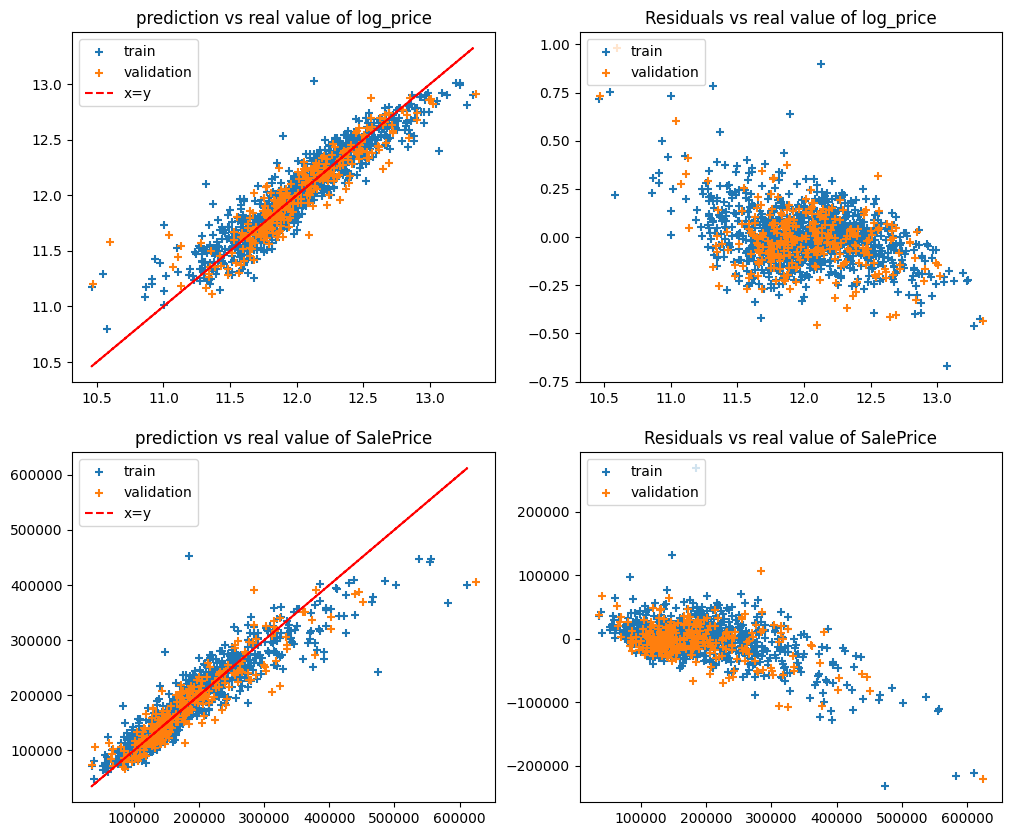

<Axes: xlabel='coefficient', ylabel='feature'>

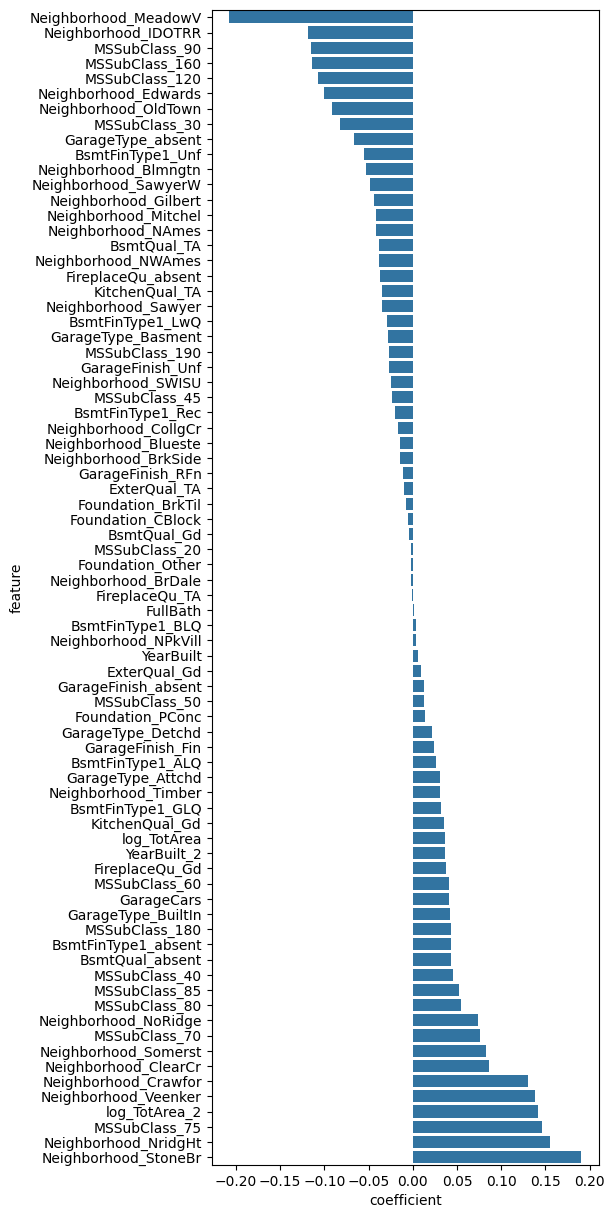

In [28]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

cv_train =[]
cv_test = []
for alpha in alphas:
    model = make_pipeline(StandardScaler(), Ridge(alpha = alpha))
    rmse_train, rmse_test = rmse_cv(model)
    cv_train.append(rmse_train)
    cv_test.append(rmse_test)


model = plot_model(Ridge(1))
coefficients = model.coef_
intercept = model.intercept_

df_coeff = pd.DataFrame({'feature':X_train.columns,
              'coefficient':coefficients}
              )
df_coeff.sort_values(by='coefficient', inplace=True)

plt.figure(figsize=(5,15))
sns.barplot(df_coeff, x='coefficient', y='feature', orient='h')


- The performances don't vary much for different values for alpha. That makes sense since the predictions wasn't suffering from variance  
=> Arbitrarily we take alpha = 1
- The coefficent are way more reasonnable. As expected the most important coefficient are the one related to Neighborhood and TotArea

## Conclusion  
The model has reasonnable predictions, even though it has less performances towards high price values. We used 14 features that allowed us to keep relatively simple model. The coefficent of the regression are also in a reasonnable range that helps increase interpretability.  

From the fact that for a simple Linear regression, some coefficents could get very high without harming the performances, we can assume that some variables are still highly correlated. Conducting analysis on the dependent between categorical variable could be beneficial. 

In order to improve the model:  
- We would try to segment the data into 2 segments : Over and under a certain threeshold in SalePrice ($400k ?). By doing that we could rectify the errors on the high values 
- It would be great to dig deeper into the categorical features that are imbalanced
- Since we don't have a variance problem, we could easily add some quadratic features, try some more complex models and add some more variables 